<a href="https://colab.research.google.com/github/pratik-poudel/financial_news_stock/blob/master/done_all_steps_1_pos_neg_only.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mlxtend --upgrade

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional,LSTM, GlobalMaxPool1D, Dense
from tensorflow.keras.utils import to_categorical, plot_model


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score,precision_recall_fscore_support
from sklearn.utils import resample, shuffle


from mlxtend.plotting import plot_confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

# Financial Phrase Bank

In [129]:
fin_data = pd.read_table('/content/Sentences_AllAgree.txt', delimiter='\r\n')

In [130]:
values = np.array([fin_data.values[i][0].split('@') for i in range(fin_data.shape[0])])
data = pd.DataFrame({'sentence': values[:, 0], 'sentiment':values[:, 1]})

In [131]:
data.head(2)

,sentence,sentiment
0,"For the last quarter of 2010 , Componenta 's n...",positive
1,"In the third quarter of 2010 , net sales incre...",positive


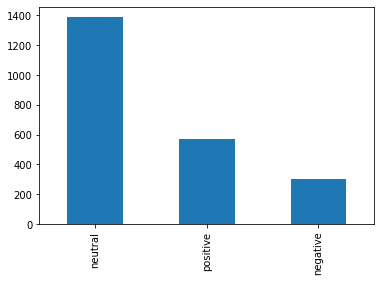

In [132]:
data['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [133]:
X= data.sentence
y = data.sentiment

In [134]:
neu = y[y == 'neutral'].index

In [135]:
X= X.drop(neu)
y = y.drop(neu)

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=60)
print("Distribution of sentiments in train data\n",  y_train.value_counts().reset_index().values)
print()
print("Distribution of sentiments in test data\n", y_test.value_counts().reset_index().values)

Distribution of sentiments in train data
 [['positive' 427]
 ['negative' 227]]

Distribution of sentiments in test data
 [['positive' 143]
 ['negative' 76]]


In [137]:
pos_index = y_train[y_train == 'positive'].index
neg_index = y_train[y_train == 'negative'].index

In [138]:
X_train_neg, y_train_neg = resample(X_train.loc[neg_index], y_train.loc[neg_index], 
                                    n_samples = len(pos_index), replace=True, random_state=60)

In [139]:
X_train = X_train.loc[pos_index].append(X_train_neg)
y_train = y_train.loc[pos_index].append(y_train_neg)
X_train, y_train = shuffle(X_train, y_train, random_state=60)

In [140]:
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

In [141]:
test_data['sentiment'].value_counts()

positive    143
negative     76
Name: sentiment, dtype: int64

In [142]:
train_data['sentiment'].value_counts()

positive    427
negative    427
Name: sentiment, dtype: int64

## BiLSTM Model

### Preparing data to feed in model 

In [143]:
X_train.iloc[0]

'The move was triggered by weak demand for forestry equipment and the uncertain market situation .'

In [144]:
# Remove Punctuation and assign integer to each word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [145]:
print("Sequences --> ", X_train[0])
print("Original sentence all lower cased \n", " ".join([tokenizer.index_word.get(i) for i in X_train[0]]))

Sequences -->  [1, 520, 48, 659, 16, 445, 274, 12, 521, 160, 10, 1, 660, 84, 275]
Original sentence all lower cased 
 the move was triggered by weak demand for forestry equipment and the uncertain market situation


In [146]:
print("Sequences length sample 1:", len(X_train[0])," sample 2:", len(X_train[1]))
print("Max length of sequence is ", np.max([len(X_train[i]) for i in range(len(X_train))]))

Sequences length sample 1: 15  sample 2: 28
Max length of sequence is  53


In [147]:
# Make sequences of equal length 
max_len = np.max([len(X_train[i]) for i in range(len(X_train))])
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [148]:
print("After padding 1st sample became \n", X_train[0])

After padding 1st sample became 
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   1 520  48 659  16 445 274  12 521 160  10   1 660  84 275]


In [149]:
# Convert sentiment values to one hot encoded for Keras model
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [212]:
le.inverse_transform([0, 1])

array(['negative', 'positive'], dtype=object)

### Model Building

In [375]:
EMBEDDING_DIM = 100
VOCAB_SIZE = len(tokenizer.word_index)

model = Sequential()
model.add(Embedding(VOCAB_SIZE +1, EMBEDDING_DIM, input_length=max_len))
model.add(Dropout(0.30))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='sum'))
model.add(Dropout(0.3))
model.add(GlobalMaxPool1D())
model.add(Dense(16, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 53, 100)           215000    
_________________________________________________________________
dropout_40 (Dropout)         (None, 53, 100)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 53, 200)           481600    
_________________________________________________________________
dropout_41 (Dropout)         (None, 53, 200)           0         
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 200)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 16)                3216      
_________________________________________________________________
dropout_42 (Dropout)         (None, 16)              

In [365]:
# plot_model(model)

In [376]:
#Train Model

batch_size = 64
epochs = 8
model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, verbose=1, epochs=epochs, shuffle=True)

Epoch 1/8
14/14 [==============================] - 4s 82ms/step - loss: 0.7942 - accuracy: 0.4679 - precision: 0.4147 - recall: 0.3037 - val_loss: 0.7199 - val_accuracy: 0.3470 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
14/14 [==============================] - 0s 20ms/step - loss: 0.6948 - accuracy: 0.5349 - precision: 0.5352 - recall: 0.5267 - val_loss: 0.6724 - val_accuracy: 0.7032 - val_precision: 0.6970 - val_recall: 0.9650
Epoch 3/8
14/14 [==============================] - 0s 20ms/step - loss: 0.6388 - accuracy: 0.6271 - precision: 0.6008 - recall: 0.8103 - val_loss: 0.7538 - val_accuracy: 0.6484 - val_precision: 0.8173 - val_recall: 0.5944
Epoch 4/8
14/14 [==============================] - 0s 20ms/step - loss: 0.5226 - accuracy: 0.8000 - precision: 0.8157 - recall: 0.7688 - val_loss: 0.5615 - val_accuracy: 0.7580 - val_precision: 0.7848 - val_recall: 0.8671
Epoch 5/8
14/14 [==============================] - 0s 21ms/step - loss: 0.3283 - accuracy: 0.9197 - prec

In [377]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
print("Testing auc : {:.2f}".format(test_acc * 100))

Testing auc : 80.82


In [378]:
preds = model.predict(X_test, batch_size=batch_size)

In [379]:
roc_auc_score(y_test, preds)

0.8353882959146118

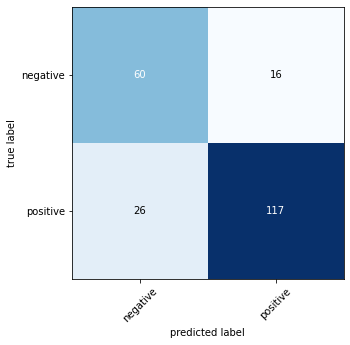

In [380]:
c_mat = confusion_matrix(y_test, np.round(preds))
plot_confusion_matrix(c_mat, cmap='Blues', class_names = le.classes_, figsize=(5, 5))
plt.show()

In [381]:
# Precision, recall, f1 score and support
# Precision, recall, f1 score and support
p, r, f1, s = precision_recall_fscore_support(y_test, np.round(preds), average=None)

# Print precision, recall, f1 score and support
results = pd.DataFrame({'1-Precision': p, '2-Recall': r, '3-F1 score': f1, '4-Support': s}, index=le.classes_)

# Print precision, recall, f1 score and support
print(results.round(decimals=3))

          1-Precision  2-Recall  3-F1 score  4-Support
negative        0.698     0.789       0.741         76
positive        0.880     0.818       0.848        143


# Prepare NEPSE DATA

In [397]:
indices = pd.read_csv('/content/Nepse Indices - Sheet1.csv', header=1)
indices.columns= ['no_name', 'date', 'index', 'abs_change', 'pct_change']
indices['date'] = pd.to_datetime(indices['date'])
indices = indices[indices['date'] < '2019-07-06']

In [398]:
news_df = pd.read_csv('/content/years_combined_df.csv')
news_df['date'] = pd.to_datetime(news_df['date'])
news_df = news_df[news_df['date'] >= '2014-02-02']
news_df.reset_index(drop=True, inplace=True)

In [399]:
news_df = news_df[news_df['date'].isin(indices['date'])].reset_index(drop=True)

In [400]:
indices = indices[indices['date'].isin(news_df['date'])].reset_index(drop=True)

In [401]:
indices['pct_change'] = indices['pct_change'].str.replace('%', '').astype(float)

In [402]:
def prepare_and_predict_news(series, pad_max_len, batch_size):

    news = tokenizer.texts_to_sequences(series)
    news = pad_sequences(news, pad_max_len)
    news = model.predict(news, batch_size=batch_size)
    return news

In [403]:
news_sentiment = prepare_and_predict_news(news_df['content'], pad_max_len=max_len, batch_size=batch_size)

In [404]:
news_sentiment

array([[0.05395554],
       [0.8353655 ],
       [0.04956882],
       ...,
       [0.05464776],
       [0.8362216 ],
       [0.08227021]], dtype=float32)

In [405]:
blstm_preds = pd.DataFrame(news_sentiment, columns=['blstm_preds'])

In [407]:
news_sent_combined = pd.concat([news_df, blstm_preds], axis=1)

In [415]:
for date, i, j in zip(news_sent_combined['date'].dt.date, news_sent_combined['content'][:100], news_sent_combined['blstm_preds'][:100]):
    print(date, i, "\n", j)
    print()

2014-02-02 Nepal Stock Exchange (Nepse) slid 2.22 points to close at 781.46 points last week. 
 0.05395553633570671

2014-02-02 Moffat Nyirenda is president of Round Table International. 
 0.8353654742240906

2014-02-02 The government has stopped monitoring of shops dealing in readymade garment and shoes although previous inspections have revealed rampant malpractices. 
 0.04956882447004318

2014-02-02 The Ministry of Industry (MoI) is preparing to recommend the Cabinet to declare Pokhara-based Fulbari Resort and Chitwan-based Chitwan Wildlife Lodge 
 0.8335683941841125

2014-02-02 The delivery of Chinese aircraft for Nepal Airlines Corporation (NAC) will be delayed by a month. 
 0.043842948973178864

2014-02-03 Talking about pricey threads, the domestic market will soon get to witness the launch of a suiting brand costing upwards of Rs 300,000. 
 0.831755518913269

2014-02-03 Cross-border trade with India via Janakpur has come to a complete halt after Janakpur Railway suspended its Ja

In [391]:
mean_sentiment = pd.DataFrame(news_sent_combined.groupby('date')['blstm_preds'].apply(np.mean))
mean_sentiment.reset_index(inplace=True)

In [392]:
mean_sentiment = pd.concat([indices, mean_sentiment],axis=1)

In [393]:
mean_sentiment['target'] = np.where(mean_sentiment['pct_change'] < 0 , 0, 1)

In [394]:
mean_sentiment['blstm_predicted'] = mean_sentiment['blstm_preds'].round().astype(int)

In [395]:
roc_auc_score(mean_sentiment['target'], mean_sentiment['blstm_preds'])

0.49457522227879835

In [396]:
accuracy_score(mean_sentiment['target'], mean_sentiment['blstm_predicted'])

0.48465266558966075

In [ ]:
imdb_train, ds_info = tfds.load(name="imdb_reviews", split="train", 
                                with_info=True, as_supervised=True)
imdb_test = tfds.load(name="imdb_reviews", split="test", 
                      as_supervised=True)

In [ ]:
imdb_train = tfds.as_dataframe(imdb_train, ds_info)
imdb_test = tfds.as_dataframe(imdb_test, ds_info)

In [ ]:
imdb_train = imdb_train.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
imdb_test = imdb_test.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

In [ ]:
X_train = imdb_train['text']
y_train = imdb_train['label']
X_test = imdb_test['text']
y_test = imdb_test['label']

In [ ]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test= tokenizer.texts_to_sequences(X_test)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
max_len = np.max([len(X_train[i]) for i in range(len(X_train))])

In [ ]:
Tokenizer()

In [ ]:
X_train = pad_sequences(X_train, maxlen=150, padding='post', )
X_test = pad_sequences(X_test, maxlen = 150, padding='post')

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
n_classes = 1
def build_model_lstm(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
    mask_zero=True),
    tf.keras.layers.LSTM(rnn_units),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model



In [ ]:
vocab_size = len(word_index) +1
# The embedding dimension
embedding_dim = 64
# Number of RNN units
rnn_units = 64
# batch size
BATCH_SIZE=100
model = build_model_lstm(
    vocab_size = vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          5669312   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,702,401
Trainable params: 5,702,401
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy', 'Precision', 'Recall'])

model.fit(X_train, y_train, epochs=10, batch_size=BATCH_SIZE, verbose=1)


Epoch 1/10
250/250 [==============================] - 13s 42ms/step - loss: 0.5405 - accuracy: 0.7022 - precision: 0.7034 - recall: 0.7006
Epoch 2/10
250/250 [==============================] - 11s 42ms/step - loss: 0.1774 - accuracy: 0.9366 - precision: 0.9344 - recall: 0.9400
Epoch 3/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0855 - accuracy: 0.9739 - precision: 0.9753 - recall: 0.9726
Epoch 4/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0499 - accuracy: 0.9856 - precision: 0.9844 - recall: 0.9867
Epoch 5/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0265 - accuracy: 0.9928 - precision: 0.9938 - recall: 0.9919
Epoch 6/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0303 - accuracy: 0.9909 - precision: 0.9922 - recall: 0.9897
Epoch 7/10
250/250 [==============================] - 10s 42ms/step - loss: 0.0358 - accuracy: 0.9872 - precision: 0.9885 - recall: 0.9856
Epoch 8/10
250/250 [=======

In [ ]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

250/250 [==============================] - 3s 7ms/step - loss: 0.8269 - accuracy: 0.8362 - precision: 0.8356 - recall: 0.8370


[0.826852023601532, 0.8361600041389465, 0.8355693817138672, 0.8370400071144104]

In [ ]:
model.predict(X_test[0])

0.47636515299479165

In [ ]:
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

In [ ]:
EMBEDDING_DIM = 300
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_len))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(200, return_sequences=True), merge_mode='concat'))
model.add(Dropout(0.25))
model.add(GlobalMaxPool1D())
model.add(Dense(50, activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 2493, 300)         26574900  
_________________________________________________________________
dropout (Dropout)            (None, 2493, 300)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 2493, 400)         801600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2493, 400)         0         
_________________________________________________________________
global_max_pooling1d (Global (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                20050     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

In [ ]:
batch_size = 64
epochs = 10
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,verbose=1)

Epoch 1/10
391/391 [==============================] - 35s 91ms/step - loss: 0.2858 - accuracy: 0.8836
Epoch 2/10
391/391 [==============================] - 35s 90ms/step - loss: 0.2051 - accuracy: 0.9219
Epoch 3/10
391/391 [==============================] - 35s 90ms/step - loss: 0.1554 - accuracy: 0.9426
Epoch 4/10
391/391 [==============================] - 35s 90ms/step - loss: 0.1183 - accuracy: 0.9592
Epoch 5/10
391/391 [==============================] - 35s 90ms/step - loss: 0.0844 - accuracy: 0.9712
Epoch 6/10
391/391 [==============================] - 35s 90ms/step - loss: 0.0571 - accuracy: 0.9808
Epoch 7/10
391/391 [==============================] - 35s 90ms/step - loss: 0.0411 - accuracy: 0.9863
Epoch 8/10
391/391 [==============================] - 36s 91ms/step - loss: 0.0280 - accuracy: 0.9912
Epoch 9/10
391/391 [==============================] - 35s 91ms/step - loss: 0.0179 - accuracy: 0.9943
Epoch 10/10
391/391 [==============================] - 35s 91ms/step - loss: 0.012

In [ ]:
model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)

250/250 [==============================] - 4s 13ms/step - loss: 0.6060 - accuracy: 0.8502


[0.6059731841087341, 0.8501999974250793]

In [ ]:
model.predict(X_test[0])

array([[3.94611120e-01, 6.05388880e-01],
       [7.62499988e-01, 2.37499967e-01],
       [9.99360025e-01, 6.39992417e-04],
       [2.54454720e-03, 9.97455418e-01],
       [2.42744815e-02, 9.75725532e-01],
       [5.18489957e-01, 4.81509984e-01],
       [1.93062499e-01, 8.06937516e-01],
       [8.01742554e-01, 1.98257491e-01],
       [6.38091326e-01, 3.61908704e-01],
       [4.71223384e-01, 5.28776646e-01],
       [8.80347371e-01, 1.19652607e-01],
       [3.91476555e-04, 9.99608576e-01],
       [9.98337388e-01, 1.66256400e-03],
       [3.48617882e-01, 6.51382089e-01],
       [5.72086036e-01, 4.27913964e-01],
       [9.84464467e-01, 1.55354915e-02],
       [1.09254186e-04, 9.99890685e-01],
       [1.99941069e-01, 8.00058901e-01],
       [8.08977187e-01, 1.91022769e-01],
       [5.03213584e-01, 4.96786386e-01],
       [8.48092139e-01, 1.51907936e-01],
       [9.69207048e-01, 3.07929907e-02],
       [5.03213584e-01, 4.96786386e-01],
       [8.48092139e-01, 1.51907936e-01],
       [6.921743